# Введение

Наша цель - разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

Для достижени цели нам нужно выполнить следующие задачи:

- провести загрузку и осмотр данных;
- исследовательский анализ данных;
- внести изменения, если потребуется;
- выбрать наилучший способ оценки изображений;
- сделать очистку текста, токенизацию и векторизацию;
- осуществить векторизацию изображений;
- сконкатенировать получившиеся вектора;
- разработать несколько моделей, одна из которых будет линейная регрессия, другая - полносвязная нейронная сеть;
- протестировать модель.

По возможности, для каждого пункта будем делать визуализацию и промежуточные выводы.

Стартовые условия:
- в файле train_dataset.csv находится информация, необходимая для обучения;
- в папке train_images содержатся изображения для тренировки модели;
- в файле CrowdAnnotations.tsv  — данные по соответствию изображения и описания, полученные с помощью краудсорсинга;
- в файле ExpertAnnotations.tsv  — данные по соответствию изображения и описания, полученные в результате опроса экспертов;
- в файле test_queries.csv находится информация, необходимая для тестирования;
- в папке test_images содержатся изображения для тестирования модели;

Для достижения задач будем использовать фреймворк **Keras** (просто потому, что PyTorch у меня не хочет работать, времени возиться просто нет).

# Загрузка и осмотр данных

Сначала загрузим необходимые библиотеки и модули.

In [1]:
# БАЗОВЫЕ БИБЛИОТЕКИ
import os
import re
import ast
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import random

# NLP И ТЕКСТ
import stanza
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

# ОБРАБОТКА ИЗОБРАЖЕНИЙ
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Concatenate
from tensorflow.keras.optimizers import Adam

# ОБРАБОТКА ДАННЫХ
from sklearn.preprocessing import StandardScaler, normalize, Normalizer
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit, cross_val_score
from collections import Counter
from joblib import dump, load
import pickle

# МОДЕЛИ
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, BatchNormalization, GlobalAveragePooling2D
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

# МЕТРИКИ
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix,
    mean_squared_error, 
    mean_absolute_error, 
    r2_score
)

Передадим переменным пути обращения к данным.

In [2]:
true_path = r"E:\dsplus_integrated_project_4\to_upload"

image_dir = os.path.join(true_path, "train_images")
final_test_image_dir = os.path.join(true_path, "test_images")

final_test_img_names = pd.read_csv(os.path.join(true_path, 'test_images.csv'))

train_df = pd.read_csv(os.path.join(true_path, 'train_dataset.csv'))
expert_df = pd.read_csv(os.path.join(true_path, 'ExpertAnnotations.tsv'), sep='\t', header=None)
crowd_df = pd.read_csv(os.path.join(true_path, 'CrowdAnnotations.tsv'), sep='\t', header=None)
final_test_df = pd.read_csv(os.path.join(true_path, 'test_queries.csv'), sep='|')

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
    <b>v2</b> исправлено 👍 </div>

In [3]:
train_df.info()
print('\n')
expert_df.info()
print('\n')
crowd_df.info()
print('\n')
final_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       5822 non-null   object
 1   1       5822 non-null   object
 2   2       5822 non-null   int64 
 3   3       5822 non-null   int64 
 4   4       5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       47830 non-null  object 
 1   1       47830 

In [4]:
display("ТРРЕНИРОВОЧНЫЙ", train_df.head(3))
display("ЭКСПЕРТНЫЙ", expert_df.head(3))
display("КРАУНДИНГОВЫЙ", crowd_df.head(3))
display("ТЕСТОВЫЙ", final_test_df.head(3))

'ТРРЕНИРОВОЧНЫЙ'

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


'ЭКСПЕРТНЫЙ'

,0,1,2,3,4
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2


'КРАУНДИНГОВЫЙ'

,0,1,2,3,4
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3


'ТЕСТОВЫЙ'

,Unnamed: 0,query_id,query_text,image
0,0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg


Судя по всему, названия колонок содержат мусор и взяты из первых строк датасетов. Исправим.

In [5]:
expert_df.columns = ['image', 'query_id', 'expert1', 'expert2', 'expert3']
crowd_df.columns = ['image', 'query_id', 'rate', 'match', 'not_match']

В тестовом датасете есть непонятный столбец unnamed:0. Он просто дублирует индексы, избавимся от него.

In [6]:
final_test_df = final_test_df.drop(['Unnamed: 0'], axis=1)

Посмотрим на изображения.


Папка: train
Количество изображений: 1000
Средний размер изображений: 455.9 x 398.3


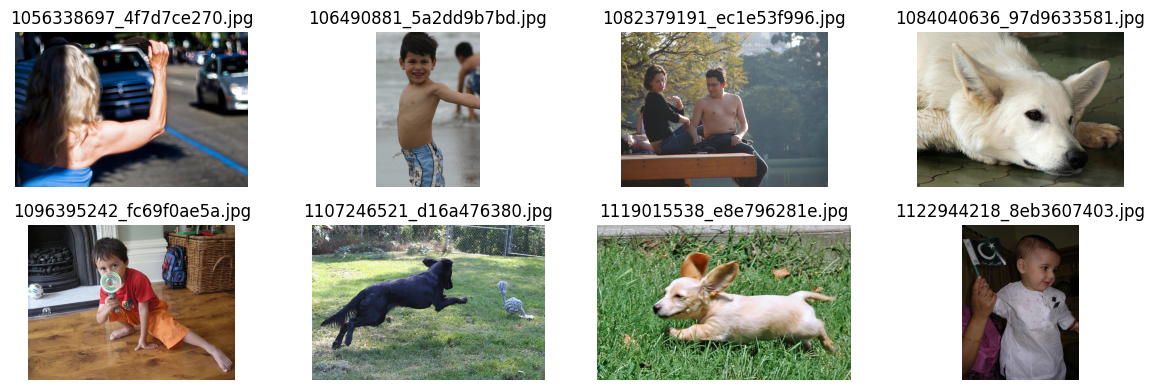


Папка: final_test
Количество изображений: 100
Средний размер изображений: 461.4 x 386.4


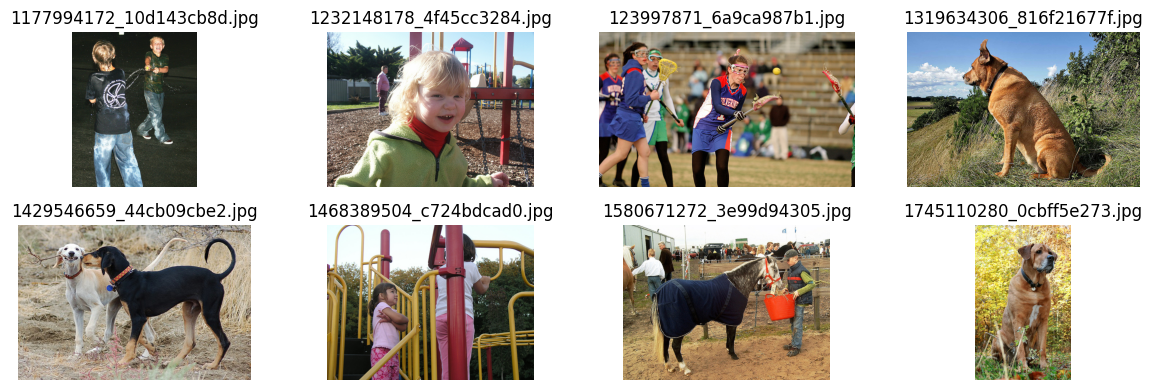

In [7]:

folders = {
    "train": image_dir,
    "final_test": final_test_image_dir
}

for name, folder in folders.items():
    print(f"\nПапка: {name}")
    images = [f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"Количество изображений: {len(images)}")
    sizes = []
    for img_file in images:
        path = os.path.join(folder, img_file)
        with Image.open(path) as img:
            sizes.append(img.size) 
    sizes = np.array(sizes)
    mean_width, mean_height = sizes[:,0].mean(), sizes[:,1].mean()
    print(f"Средний размер изображений: {mean_width:.1f} x {mean_height:.1f}")
    
    plt.figure(figsize=(12, 4))
    for i, img_file in enumerate(images[:8]):
        path = os.path.join(folder, img_file)
        with Image.open(path) as img:
            plt.subplot(2, 4, i+1)
            plt.imshow(img)
            plt.title(img_file)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

Вывод по осмотру изображений. Все изображения имеют разный размер, нужно будет приводить их к одному масштабу, так как моделям проще обучаться на одинаковых.

Взглянем на распределение оценок в экспертном и краундинговом датасете

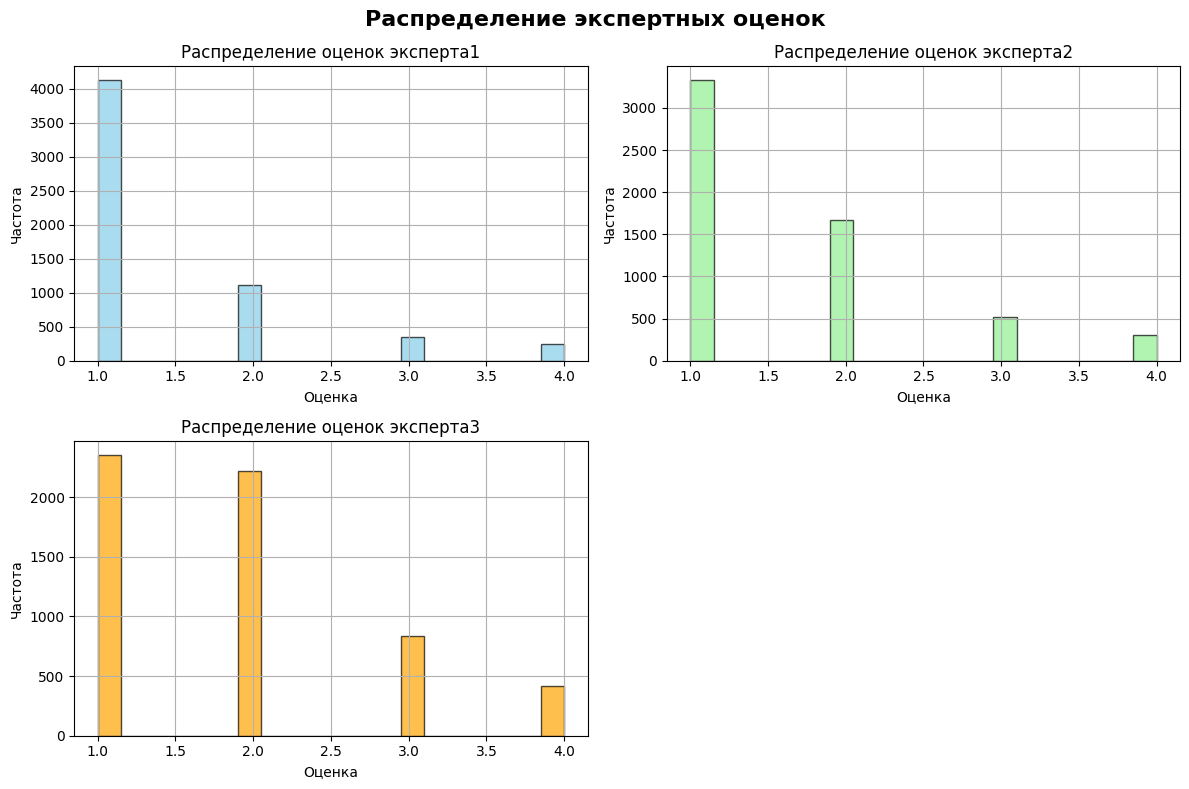

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

expert_df['expert1'].hist(ax=axes[0], bins=20, color='skyblue', alpha=0.7, edgecolor='black')
axes[0].set_title('Распределение оценок эксперта1')
axes[0].set_xlabel('Оценка')
axes[0].set_ylabel('Частота')

expert_df['expert2'].hist(ax=axes[1], bins=20, color='lightgreen', alpha=0.7, edgecolor='black')
axes[1].set_title('Распределение оценок эксперта2')
axes[1].set_xlabel('Оценка')
axes[1].set_ylabel('Частота')

expert_df['expert3'].hist(ax=axes[2], bins=20, color='orange', alpha=0.7, edgecolor='black')
axes[2].set_title('Распределение оценок эксперта3')
axes[2].set_xlabel('Оценка')
axes[2].set_ylabel('Частота')

plt.suptitle('Распределение экспертных оценок', fontsize=16, fontweight='bold')
axes[3].axis('off')
plt.tight_layout()
plt.show()


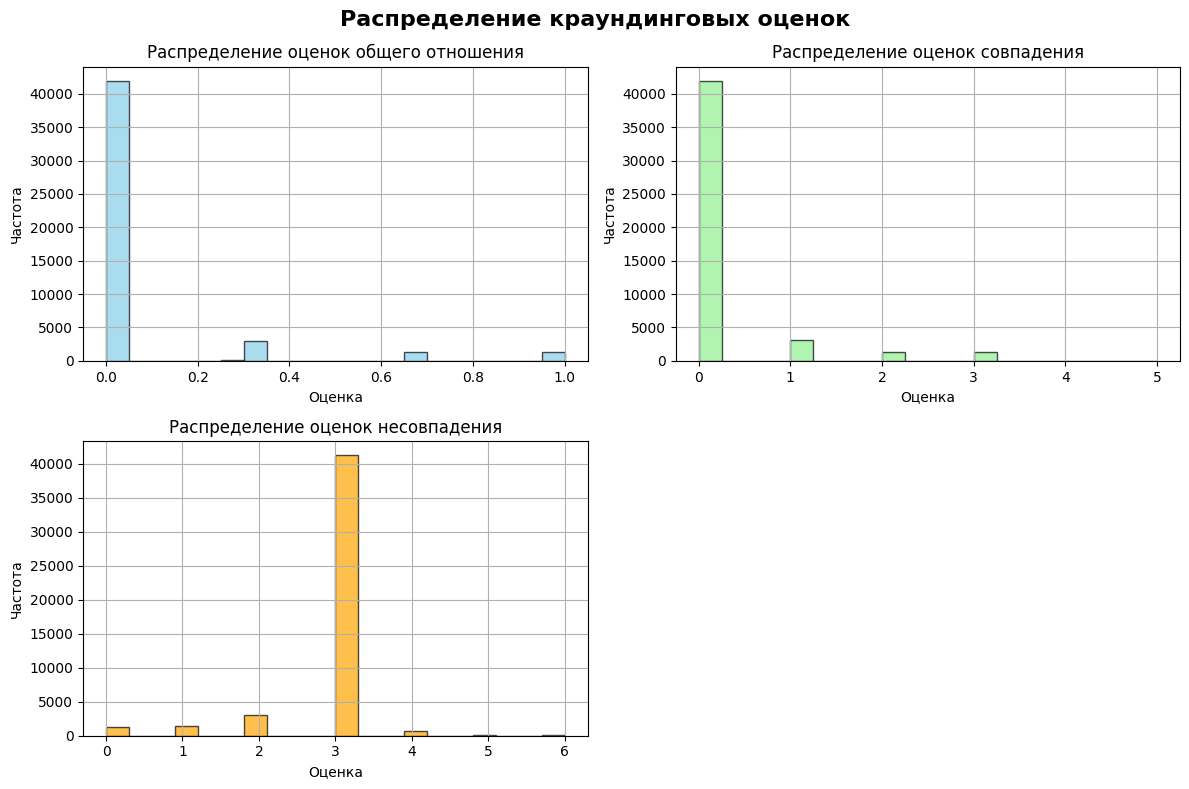

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

crowd_df['rate'].hist(ax=axes[0], bins=20, color='skyblue', alpha=0.7, edgecolor='black')
axes[0].set_title('Распределение оценок общего отношения')
axes[0].set_xlabel('Оценка')
axes[0].set_ylabel('Частота')

crowd_df['match'].hist(ax=axes[1], bins=20, color='lightgreen', alpha=0.7, edgecolor='black')
axes[1].set_title('Распределение оценок совпадения')
axes[1].set_xlabel('Оценка')
axes[1].set_ylabel('Частота')

crowd_df['not_match'].hist(ax=axes[2], bins=20, color='orange', alpha=0.7, edgecolor='black')
axes[2].set_title('Распределение оценок несовпадения')
axes[2].set_xlabel('Оценка')
axes[2].set_ylabel('Частота')

plt.suptitle('Распределение краундинговых оценок', fontsize=16, fontweight='bold')
axes[3].axis('off')
plt.tight_layout()
plt.show()

Сразу задаем заголовки согласно указанному в задаче. Количество строк в тренировочном датафрейме соответствует количеству текстовых строк. Экспертный аналогичен тренировочному по размеру. Вопрос доверия - в краундинговом датасете оценки ставили люди не имеющие, так сказать, профессионализма при выборе. Кроме того, такие не совсем ясные и порой неточные оценки сильно будут размывать итоговый балл, который по итогу может быть некорректным. 
Судя по графикам, экспертные оценки имеют более сбалансированный датасет, плавное распределение оценок. Краундинговый датасет содержит огромное количество несовпавших картинок с текстом, это сильно повлияет на обучение. 
Выберем для исследования и работы экспертов.

Соединим датафреймы. Присоединим экспертов к тренировочному. Применим логику объединения inner join. В результате этого объединения в итоговый датафрейм попадут только те строки, которые есть в обоих датасетах. Предполагаю, что учитывая примерный размер обоих датасетов, итоговый будет соединен без потерь.

In [10]:
train_full = train_df.merge(expert_df, on=['image', 'query_id'], how='inner')

In [11]:
train_full.head(3)

,image,query_id,query_text,expert1,expert2,expert3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,2,2


Создадим общую итоговую оценку final_total, которая объединит оценки экспертов. Возьмем среднее по экспертам.

In [12]:
def normalize_votes(row):
    votes = [row['expert1'], row['expert2'], row['expert3']]
    mean_vote = np.mean(votes)
    return (mean_vote - 1) / 3

train_full['total_final'] = train_full.apply(normalize_votes, axis=1)
train_full = train_full.dropna(subset=['total_final'])

print(f"После агрегации осталось {len(train_full)} пар (из {len(train_df)})")
print(f"Объединённый датасет: {train_full.shape}")

После агрегации осталось 5822 пар (из 5822)
Объединённый датасет: (5822, 7)


Посмотрим на получившийся результат.

In [13]:
train_full.head(3)
print('\n')
train_full.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        5822 non-null   object 
 1   query_id     5822 non-null   object 
 2   query_text   5822 non-null   object 
 3   expert1      5822 non-null   int64  
 4   expert2      5822 non-null   int64  
 5   expert3      5822 non-null   int64  
 6   total_final  5822 non-null   float64
dtypes: float64(1), int64(3), object(3)
memory usage: 318.5+ KB


<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
ОК, данные загружены, проведено знакомство. Также вижу что ты получил мастер-датафрейм.</div>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">
    
    
Но все-таки стоит показать полученный результат,  т.к. это очень важный промежуточный шаг.  Выведи head + info </div>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">
<b>v3</b>    

Или это невнимательность или непонимание основ - как работает jupyter ноутбук. В любом случае пройти мимо не имею права.
    
Обрати внимание - ты вывел результат работы info(), но тут совершенно нет результатов head? Как ты думаешь, почему?  Возможная подсказка в комментарии ниже.
    
</div>

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
<b>минутка теории</b> 
 По умолчанию jupyter notebook выводит результат вычислений в последней строке ячейки, если этот результат не записан в переменную. Мы часто пользуемся этим, обратившись к какому-нибудь объекту в последней строке и видим результат без дополнительных print() или dispay()
    
    
  Ниже три ячейки с кодом. Обрати внимание, если просто сделать вычисление - то результат выводится, но если добавить точку с запятой или записать результат в переменную, то ничего не происходит. Обрати внимание, когда происходит вывод:
   - последня строка
   - нет точки с запятой в конце
    
   - результат не записан в переменную
 
И досточно убрать одно из этих условий, как вывода нет.

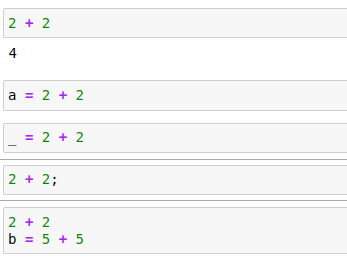    

 Функции matlitlib не только выводят графики, но и возвращают python объекты axis. Это внутренняя кухня, чтобы можно было строить сложные графики. Но для нас побочным эффектом является то, что в ноутбуке мы видим текстовое предоставление объекта, которое выводит ноутбук. И для красоты такое поведение стоит заблокировать. 



</div>

Отфильтруем строки в которых содержится рестриктовый контент. Создадим список слов, связь с изображениями которых запрещена. Нужно отфильтровать изображения, на которых есть лица не достигшие 16 лет.

In [14]:
df = train_full.copy()

exclude_words = [
    'kid', 'kids', 'toddler', 'toddlers',
    'children', 'child', 'boy', 'boys', 'girl', 'girls',
    'young', 'school', 'playfully', 'baby'
]

In [15]:
def contains_excluded_words(text, exclude_words):
    text_lower = str(text).lower()
    for word in exclude_words:
        if re.search(r'\b' + re.escape(word.lower()) + r'\b', text_lower):
            return True
    return False

bad_rows = df[df['query_text'].apply(lambda x: contains_excluded_words(x, exclude_words))]
bad_caption_ids = bad_rows['query_id'].unique()

def extract_image_name(caption_id):
    if '#' in caption_id:
        return caption_id.split('#')[0]
    return caption_id

forbidden_images_set = set()
for caption_id in bad_caption_ids:
    image_name = extract_image_name(caption_id)
    forbidden_images_set.add(image_name)

initial_count = len(df)
df = df[~df['image'].isin(forbidden_images_set)]
final_count = len(df)

print(f"\nРезультаты фильтрации:")
print(f"Исходный размер датасета: {initial_count}")
print(f"После фильтрации: {final_count}")
print(f"Удалено строк: {initial_count - final_count}")


Результаты фильтрации:
Исходный размер датасета: 5822
После фильтрации: 4020
Удалено строк: 1802


4020 строк осталось. Малое количество.

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
чистка датасета от изображений с детьми реализована корректно </div>

In [16]:
df = df.drop(['expert1', 'expert2', 'expert3'], axis=1)

In [17]:
df['total_final'].value_counts()

total_final
0.000000    1531
0.111111     641
0.333333     476
0.222222     447
0.444444     244
1.000000     201
0.666667     199
0.555556     168
0.777778      62
0.888889      51
Name: count, dtype: int64

Очень много оценок нулевых. Это может создать перекос в обучении модели.

### Вывод по осмотру и редактированию.
    
Мы отбросили краундинговый датасет из-за ненадежности и перекоса оценок. Тренировочные изображения у нас имеют разный размер, общее их количество 1000. Тестовых изображений 100.
У каждого датасета были неправильно заданы некоторые заголовки и присутствовал ненужный столбец в тестовом датасете. Количество низких оценок превалирует. Это может негативно сказаться на обучении модели. 
Мы удалили изображения связанные со словами запрещенными законом.

# Обработка текста

Сначал очистим текст от лишних символов. Работать будем через **Stanza**. Сначала очистим текст в df, затем токенизируем и векторизируем.

In [18]:
texts = df['query_text'].dropna().unique().tolist()
print(f"Всего уникальных текстов: {len(texts)}")

nlp = stanza.Pipeline('en', processors='tokenize,lemma', use_gpu=True)

def clean_texts_with_stanza(texts, batch_size=64):
    cleaned_texts = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        docs = [nlp(text) for text in batch]
        for doc in docs:
            lemmas = [w.lemma.lower() for sent in doc.sentences for w in sent.words if w.lemma.isalpha()]
            cleaned_texts.append(" ".join(lemmas))
    return cleaned_texts

cleaned_texts = clean_texts_with_stanza(texts)

vectorizer = TfidfVectorizer(max_features=10000)
tfidf_matrix = vectorizer.fit_transform(cleaned_texts)
tfidf_matrix = normalize(tfidf_matrix, norm='l2', axis=1)

text_vectors_dict = {
    text: tfidf_matrix[i].toarray()[0]
    for i, text in enumerate(texts)
}

print(f"Словарь векторов создан: {len(text_vectors_dict)} элементов")

with open('text_vectors_dict.pkl', 'wb') as f:
    pickle.dump(text_vectors_dict, f)

2025-10-31 09:18:17 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


Всего уникальных текстов: 937


2025-10-31 09:18:18 INFO: Downloaded file to C:\Users\PowerEngine\stanza_resources\resources.json
2025-10-31 09:18:18 WARNING: Language en package default expects mwt, which has been added
2025-10-31 09:18:18 INFO: Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| lemma     | combined_nocharlm |

2025-10-31 09:18:18 WARNING: GPU requested, but is not available!
2025-10-31 09:18:18 INFO: Using device: cpu
2025-10-31 09:18:18 INFO: Loading: tokenize
2025-10-31 09:18:20 INFO: Loading: mwt
2025-10-31 09:18:20 INFO: Loading: lemma
2025-10-31 09:18:20 INFO: Done loading processors!
100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.45it/s]

Словарь векторов создан: 937 элементов


# Векторизация изображений

Обработку будем проводить через Resnet50. Так как Resnet50 обучался на отредактированных изображениях то, изменим размер на 224 на 224, обрежем центр и нормализуем. 

In [19]:
unique_images = df['image'].dropna().unique().tolist()
print(f"Найдено уникальных изображений: {len(unique_images)}")

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Sequential([
    base_model,
    GlobalAveragePooling2D()
])

def extract_resnet50_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x, verbose=0)
    return features.squeeze()  # (2048,)

print("Извлекаем признаки изображений (ResNet-50)...")
image_vectors_dict = {}

for img_name in tqdm(unique_images, desc="Обработка изображений", ncols=100):
    path = os.path.join(image_dir, img_name)
    if not os.path.exists(path):
        print(f"Файл не найден: {img_name}")
        continue
    try:
        vec = extract_resnet50_features(path)
        vec = normalize(vec.reshape(1, -1), norm='l2')[0]
        image_vectors_dict[img_name] = vec
    except Exception as e:
        print(f"Ошибка при обработке {img_name}: {e}")

print(f"Словарь векторов создан: {len(image_vectors_dict)} изображений")

with open("image_vectors_dict.pkl", "wb") as f:
    pickle.dump(image_vectors_dict, f)

print("Словарь сохранён в 'image_vectors_dict.pkl'")


Найдено уникальных изображений: 699
Извлекаем признаки изображений (ResNet-50)...


Обработка изображений: 100%|██████████████████████████████████████| 699/699 [01:08<00:00, 10.25it/s]

Словарь векторов создан: 699 изображений
Словарь сохранён в 'image_vectors_dict.pkl'


# Конкатенация

По условию задачи нам нужно подать на вход модели мультимодальный вектор. Проведем соединение текстовых и визуальных признаков
Нормализуем эмибединги.

In [20]:
normalizer = Normalizer(norm='l2')

X_list = []
y_list = []

for idx, row in df.iterrows():
    img_name = row['image']
    text = row['query_text']
    
    if img_name not in image_vectors_dict or text not in text_vectors_dict:
        continue

    img_vec = image_vectors_dict[img_name].reshape(1, -1)
    text_vec = text_vectors_dict[text].reshape(1, -1)
    img_vec_norm = normalizer.fit_transform(img_vec).squeeze()
    text_vec_norm = normalizer.fit_transform(text_vec).squeeze()
    combined_vec = np.concatenate([text_vec_norm, img_vec_norm])
    X_list.append(combined_vec)
    y_list.append(row['total_final'])

X = np.vstack(X_list)
y = np.array(y_list)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (4020, 3281)
y shape: (4020,)


Применим GroupShuffleSplit чтобы одно и то же изображение не попало в разные выборки.

In [21]:
groups = df.loc[df.index[:len(y)], 'image'].values

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

train_idx, val_idx = next(gss.split(X, y, groups=groups))

X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}, y_val shape: {y_val.shape}")


X_train shape: (3216, 3281), X_val shape: (804, 3281)
y_train shape: (3216,), y_val shape: (804,)


Применим скалирование к тренировочной выборке.

# Создание моделей

Нам необходимо рассмотреть несколько моделей. Мы выберем:
- линейную регрессию
- полносвязнную нейронную сеть
- сверточную нейронную сеть
- CatBoost

## Линейная регрессия

In [22]:
model_lr = LinearRegression()

model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_val_pred = model_lr.predict(X_val)

train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Train MSE: {train_mse:.4f}, R2: {train_r2:.4f}")
print(f"Val   MSE: {val_mse:.4f}, R2: {val_r2:.4f}")


Train MSE: 0.0309, R2: 0.6141
Val   MSE: 0.1656, R2: -1.0726


Визуализация

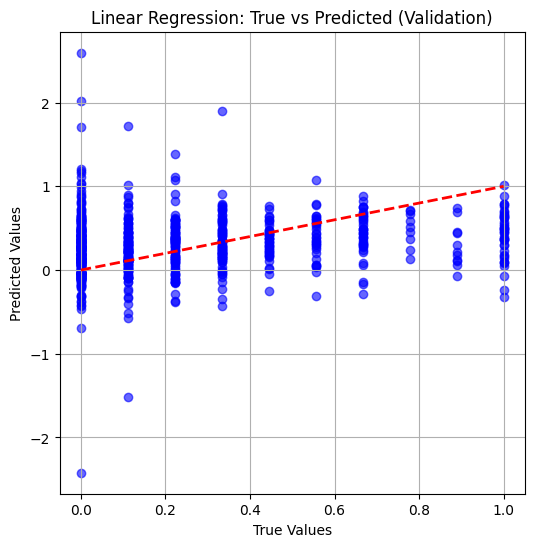

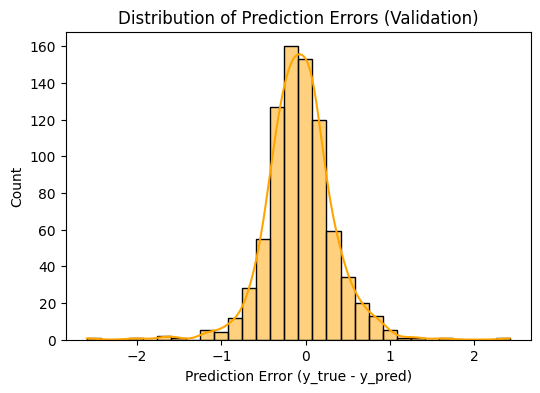

In [23]:
plt.figure(figsize=(6,6))
plt.scatter(y_val, y_val_pred, alpha=0.6, color='b')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Linear Regression: True vs Predicted (Validation)")
plt.grid(True)
plt.show()

errors = y_val - y_val_pred
plt.figure(figsize=(6,4))
sns.histplot(errors, bins=30, kde=True, color='orange')
plt.xlabel("Prediction Error (y_true - y_pred)")
plt.title("Distribution of Prediction Errors (Validation)")
plt.show()


## Полносвязная нейронная сеть

In [24]:
input_dim = X_train.shape[1]

model_sq = Sequential([
    Dense(2048, activation='relu', input_shape=(input_dim,)),
    Dropout(0.8),
    Dense(1024, activation='relu'),
    Dropout(0.6),
    Dense(512, activation='relu', input_shape=(input_dim,)),
    Dropout(0.6),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear')
])

model_sq.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae']
)

history = model_sq.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

val_loss, val_mae = model_sq.evaluate(X_val, y_val, verbose=0)
y_train_pred = model_sq.predict(X_train)
y_val_pred = model_sq.predict(X_val)

train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
print(f"Train R²: {train_r2:.4f}")
print(f"Validation R²: {val_r2:.4f}")
print(f"Validation MSE: {val_loss:.4f}, MAE: {val_mae:.4f}")


Epoch 1/50


C:\Users\PowerEngine\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0962 - mae: 0.2414 - val_loss: 0.0904 - val_mae: 0.2030
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0802 - mae: 0.2184 - val_loss: 0.0943 - val_mae: 0.2042
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0743 - mae: 0.2091 - val_loss: 0.0900 - val_mae: 0.2012
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0714 - mae: 0.2044 - val_loss: 0.0791 - val_mae: 0.1915
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0656 - mae: 0.1966 - val_loss: 0.0812 - val_mae: 0.1917
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0630 - mae: 0.1900 - val_loss: 0.0754 - val_mae: 0.1878
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0588 - mae: 0.1848 - val_loss: 0.0702 - val_mae: 0.1822
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0588 - mae: 0.1831 - val_loss: 0.0829 - val_mae: 0.1934
Epoch 9/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss

Визуализируем.

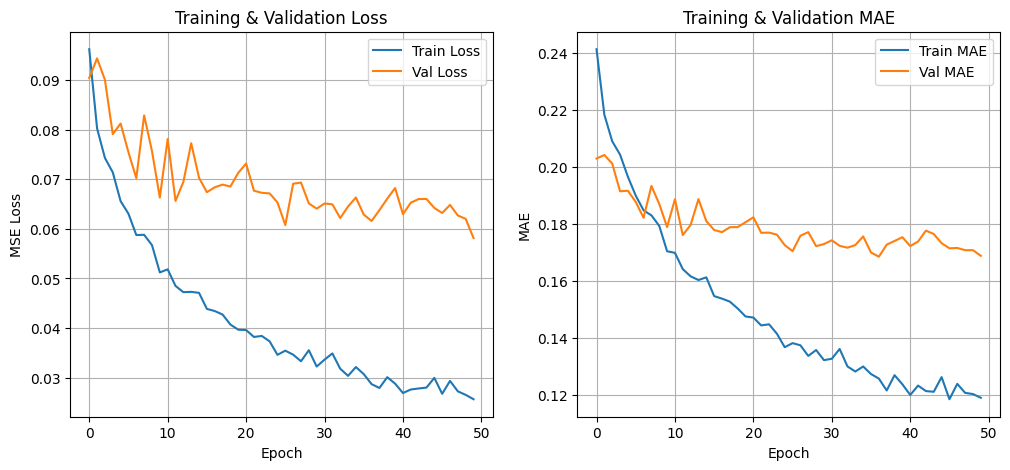

In [25]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training & Validation MAE')
plt.legend()
plt.grid(True)

plt.show()

## Сверточная нейронная сеть

In [26]:
def load_images_for_cnn(image_names, image_vectors_dict, image_dir, target_size=(224,224)):

    X_imgs = []
    missing = 0
    for img_name in tqdm(image_names):
        path = os.path.join(image_dir, img_name)
        if not os.path.exists(path):
            missing += 1
            continue
        img = load_img(path, target_size=target_size)
        img_arr = img_to_array(img)
        img_arr = preprocess_input(img_arr)
        X_imgs.append(img_arr)
    X_imgs = np.array(X_imgs, dtype=np.float32)
    print(f"Пропущено изображений: {missing}")
    return X_imgs

df = df.reset_index(drop=True)

train_images = df.loc[train_idx, 'image'].values
val_images   = df.loc[val_idx, 'image'].values


X_train_img = load_images_for_cnn(train_images, image_vectors_dict, image_dir)
X_val_img = load_images_for_cnn(val_images, image_vectors_dict, image_dir)

X_train_text = X_train[:, :X_train.shape[1] - 2048]
X_val_text = X_val[:, :X_val.shape[1] - 2048]

y_train = y_train
y_val = y_val

print(f"X_train_img: {X_train_img.shape}, X_train_text: {X_train_text.shape}")

img_input = Input(shape=(224, 224, 3), name="image_input")
text_input = Input(shape=(X_train_text.shape[1],), name="text_input")

base_cnn = ResNet50(weights='imagenet', include_top=False, input_tensor=img_input)
x = base_cnn.output
x = GlobalAveragePooling2D()(x)

t = Dense(512, activation='relu')(text_input)
t = Dropout(0.3)(t)
t = Dense(256, activation='relu')(t)

combined = Concatenate()([x, t])
combined = Dense(512, activation='relu')(combined)
combined = Dropout(0.5)(combined)
combined = Dense(256, activation='relu')(combined)
combined = Dropout(0.3)(combined)
output = Dense(1, activation='linear')(combined)

model_cnn = Model(inputs=[img_input, text_input], outputs=output)

model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',
    metrics=['mae']
)

model_cnn.summary()

history = model_cnn.fit(
    [X_train_img, X_train_text], y_train,
    validation_data=([X_val_img, X_val_text], y_val),
    epochs=30,
    batch_size=16,
    verbose=1
)

y_train_pred = model_cnn.predict([X_train_img, X_train_text])
y_val_pred = model_cnn.predict([X_val_img, X_val_text])
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)

print(f"Train: MSE={train_mse:.4f}, MAE={train_mae:.4f}, R2={train_r2:.4f}")
print(f"Val  : MSE={val_mse:.4f}, MAE={val_mae:.4f}, R2={val_r2:.4f}")


100%|█████████████████████████████████████████████████████████████████████████████| 3216/3216 [00:06<00:00, 497.18it/s]


Пропущено изображений: 0


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:01<00:00, 497.11it/s]


Пропущено изображений: 0
X_train_img: (3216, 224, 224, 3), X_train_text: (3216, 1233)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ image_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 25,662,593 (97.90 MB)

 Trainable params: 25,609,473 (97.69 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 520s 2s/step - loss: 0.3243 - mae: 0.3996 - val_loss: 0.1527 - val_mae: 0.2803
Epoch 2/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 491s 2s/step - loss: 0.1083 - mae: 0.2489 - val_loss: 0.0813 - val_mae: 0.2194
Epoch 3/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 485s 2s/step - loss: 0.0880 - mae: 0.2249 - val_loss: 0.0776 - val_mae: 0.2201
Epoch 4/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 489s 2s/step - loss: 0.0781 - mae: 0.2133 - val_loss: 0.0746 - val_mae: 0.2104
Epoch 5/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 493s 2s/step - loss: 0.0727 - mae: 0.2062 - val_loss: 0.0800 - val_mae: 0.2256
Epoch 6/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 486s 2s/step - loss: 0.0659 - mae: 0.1959 - val_loss: 0.0706 - val_mae: 0.2073
Epoch 7/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 483s 2s/step - loss: 0.0604 - mae: 0.1869 - val_loss: 0.0990 - val_mae: 0.2361
Epoch 8/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 482s 2s/step - loss: 0.0568 - mae: 0.1792 - val_loss: 0.2287 - val_mae: 0.2432
Epoch 9/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 481s 2s/

Визуализация.

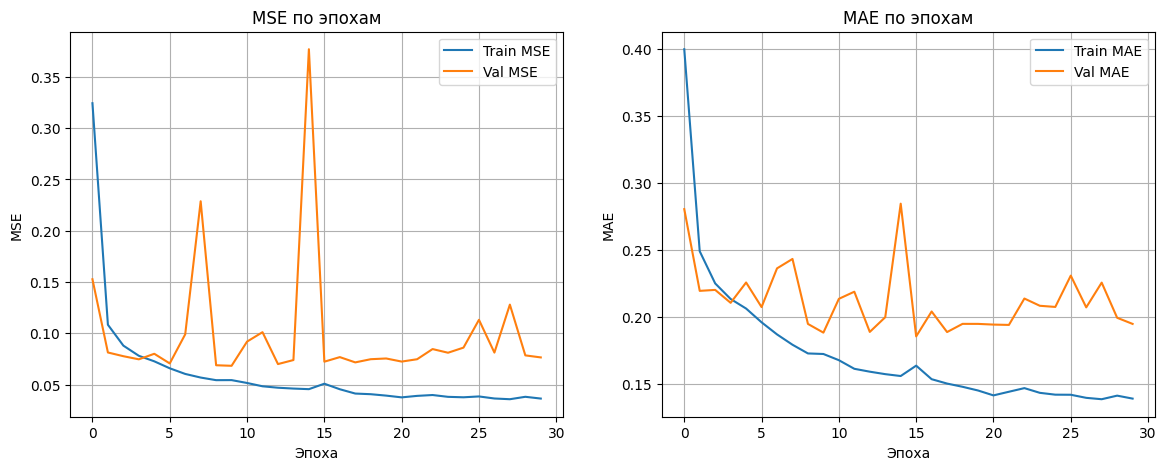

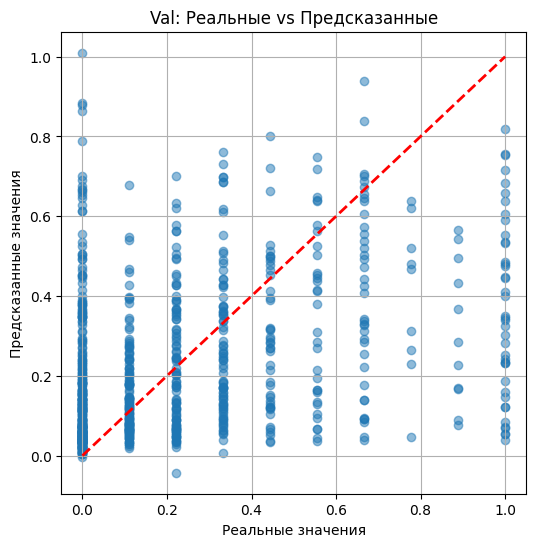

R2 на обучении: 0.6432
R2 на валидации: 0.0432


In [27]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Val MSE')
plt.title("MSE по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title("MAE по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)

plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel("Реальные значения")
plt.ylabel("Предсказанные значения")
plt.title("Val: Реальные vs Предсказанные")
plt.grid(True)
plt.show()

r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)

print(f"R2 на обучении: {r2_train:.4f}")
print(f"R2 на валидации: {r2_val:.4f}")


## CatBoost

In [28]:

cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    eval_metric='MAE',
    random_seed=42,
    verbose=100
)

train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val, y_val)

cat_model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True,
    early_stopping_rounds=50
)

y_train_pred = cat_model.predict(X_train)
y_val_pred = cat_model.predict(X_val)
train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Train MSE: {train_mse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
print(f"Val   MSE: {val_mse:.4f}, MAE: {val_mae:.4f}, R2: {val_r2:.4f}")


0:	learn: 0.2238388	test: 0.2244042	best: 0.2244042 (0)	total: 282ms	remaining: 4m 41s
100:	learn: 0.1675541	test: 0.1962714	best: 0.1962714 (100)	total: 12.6s	remaining: 1m 51s
200:	learn: 0.1496122	test: 0.1906594	best: 0.1906594 (200)	total: 26.9s	remaining: 1m 47s
300:	learn: 0.1355491	test: 0.1865618	best: 0.1865618 (300)	total: 41.3s	remaining: 1m 35s
400:	learn: 0.1243117	test: 0.1833895	best: 0.1833850 (398)	total: 55.2s	remaining: 1m 22s
500:	learn: 0.1151686	test: 0.1816334	best: 0.1816334 (500)	total: 1m 8s	remaining: 1m 8s
600:	learn: 0.1086530	test: 0.1808686	best: 0.1808686 (600)	total: 1m 21s	remaining: 54s
700:	learn: 0.1031409	test: 0.1800448	best: 0.1800448 (700)	total: 1m 34s	remaining: 40.1s
800:	learn: 0.0977602	test: 0.1789298	best: 0.1788909 (799)	total: 1m 46s	remaining: 26.4s
900:	learn: 0.0928220	test: 0.1784003	best: 0.1783852 (896)	total: 1m 59s	remaining: 13.1s
999:	learn: 0.0886603	test: 0.1776683	best: 0.1776683 (999)	total: 2m 11s	remaining: 0us

bestTes

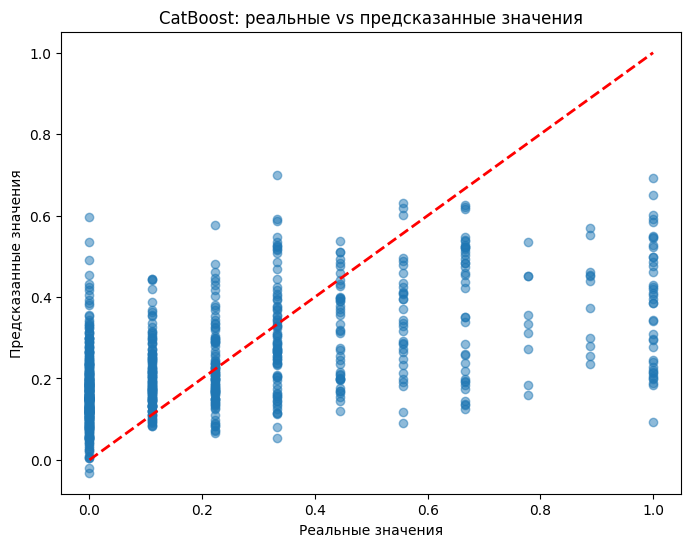

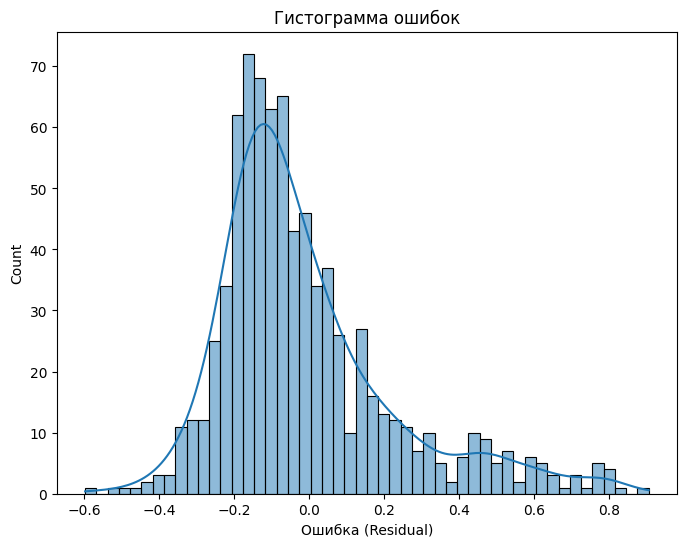

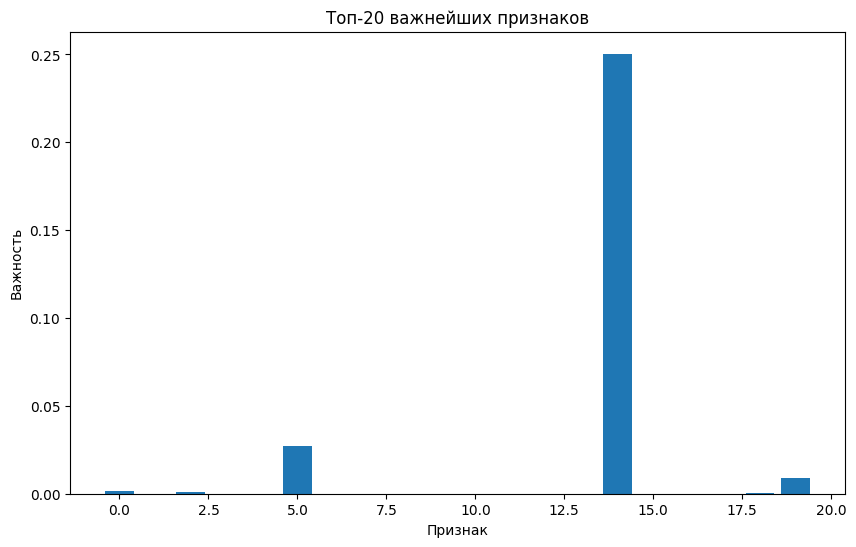

In [29]:
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', linewidth=2)
plt.xlabel("Реальные значения")
plt.ylabel("Предсказанные значения")
plt.title("CatBoost: реальные vs предсказанные значения")
plt.show()

residuals = y_val - y_val_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.xlabel("Ошибка (Residual)")
plt.title("Гистограмма ошибок")
plt.show()

importances = cat_model.get_feature_importance()
plt.figure(figsize=(10, 6))
plt.bar(range(20), importances[:20])  # Покажем топ-20 признаков
plt.xlabel("Признак")
plt.ylabel("Важность")
plt.title("Топ-20 важнейших признаков")
plt.show()


## Сравнительная таблица

Соберем результаты в одну таблицу для наглядности.

In [30]:

results = {
    "Model": [
        "Linear Regression",
        "Fully-connected NN",
        "CNN + Text NN",
        "CatBoost Regressor"
    ],
    "Train MSE": [
        mean_squared_error(y_train, model_lr.predict(X_train)),
        mean_squared_error(y_train, model_sq.predict(X_train)),
        mean_squared_error(y_train, model_cnn.predict([X_train_img, X_train_text])),
        mean_squared_error(y_train, cat_model.predict(X_train))
    ],
    "Train MAE": [
        mean_absolute_error(y_train, model_lr.predict(X_train)),
        mean_absolute_error(y_train, model_sq.predict(X_train)),
        mean_absolute_error(y_train, model_cnn.predict([X_train_img, X_train_text])),
        mean_absolute_error(y_train, cat_model.predict(X_train))
    ],
    "Train R2": [
        r2_score(y_train, model_lr.predict(X_train)),
        r2_score(y_train, model_sq.predict(X_train)),
        r2_score(y_train, model_cnn.predict([X_train_img, X_train_text])),
        r2_score(y_train, cat_model.predict(X_train))
    ],
    "Val MSE": [
        mean_squared_error(y_val, model_lr.predict(X_val)),
        mean_squared_error(y_val, model_sq.predict(X_val)),
        mean_squared_error(y_val, model_cnn.predict([X_val_img, X_val_text])),
        mean_squared_error(y_val, cat_model.predict(X_val))
    ],
    "Val MAE": [
        mean_absolute_error(y_val, model_lr.predict(X_val)),
        mean_absolute_error(y_val, model_sq.predict(X_val)),
        mean_absolute_error(y_val, model_cnn.predict([X_val_img, X_val_text])),
        mean_absolute_error(y_val, cat_model.predict(X_val))
    ],
    "Val R2": [
        r2_score(y_val, model_lr.predict(X_val)),
        r2_score(y_val, model_sq.predict(X_val)),
        r2_score(y_val, model_cnn.predict([X_val_img, X_val_text])),
        r2_score(y_val, cat_model.predict(X_val))
    ]
}

results_df = pd.DataFrame(results)

pd.set_option('display.float_format', '{:.4f}'.format)
results_df


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 96s 955ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 95s 943ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 97s 959ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 909ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 877ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 878ms/step


,Model,Train MSE,Train MAE,Train R2,Val MSE,Val MAE,Val R2
0,Linear Regression,0.0309,0.1313,0.6141,0.1656,0.2954,-1.0726
1,Fully-connected NN,0.0303,0.1266,0.6217,0.0581,0.1688,0.2724
2,CNN + Text NN,0.0286,0.1196,0.6432,0.0765,0.1947,0.0432
3,CatBoost Regressor,0.0132,0.0887,0.8351,0.0557,0.1777,0.3027


Победила модель CatBoostRegressor. Ее результаты на тренировочной выборке 0.8351 и 0.3027 на валидационной. И хоть На лицо переобучение, задачу демонстрационной версии мы выполним.

# Применение демонстрационной версии

В данном разделе нужно реализовать следующий алгоритм:

- получить на вход текст;
- обработка, токенизация, векторизация;
- из тестовых данных создать 100 конкатенированных пар;
- подать эти пары на вход обученной модели;
- получить изображение которое имеет максимальный балл;

In [31]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_model = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

test_image_vectors = []
test_image_names = []

all_test_images = os.listdir(final_test_image_dir)

for img_name in tqdm(all_test_images, desc="Векторизация тестовых изображений"):
    img_path = os.path.join(final_test_image_dir, img_name)
    try:
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        vec = feature_model.predict(x, verbose=0).squeeze()
        vec = normalize(vec.reshape(1, -1))[0]  # L2-нормализация
        test_image_vectors.append(vec)
        test_image_names.append(img_name)
    except Exception as e:
        print(f"Ошибка при обработке {img_name}: {e}")

test_image_vectors = np.array(test_image_vectors)
print(f"Векторизация завершена: {test_image_vectors.shape} изображений")


Векторизация тестовых изображений:   1%|▍                                              | 1/101 [00:02<03:55,  2.35s/it]

Ошибка при обработке .DS_Store: cannot identify image file <_io.BytesIO object at 0x000002638997CD10>


Векторизация тестовых изображений: 100%|█████████████████████████████████████████████| 101/101 [00:15<00:00,  6.34it/s]

Векторизация завершена: (100, 2048) изображений


In [32]:
lemmatizer = WordNetLemmatizer()

exclude_words = [
    'kid', 'kids', 'toddler', 'toddlers',
    'children', 'child', 'boy', 'boys', 'girl', 'girls',
    'young', 'school', 'playfully', 'baby'
]

def lemmatize_text(text):
    tokens = word_tokenize(text.lower())
    return [lemmatizer.lemmatize(token) for token in tokens]

def find_most_relevant_image(query, model, test_image_vectors, test_image_names, vectorizer, normalizer=Normalizer()):
    lemmas = lemmatize_text(query)

    if any(word in lemmas for word in exclude_words):
        return "This image is unavailable in your country in compliance with local laws."

    query_vec = vectorizer.transform([" ".join(lemmas)]).toarray()
    query_vec_norm = normalizer.fit_transform(query_vec)

    combined_vectors = np.hstack([
        np.tile(query_vec_norm, (test_image_vectors.shape[0], 1)),
        test_image_vectors
    ])
    predictions = model.predict(combined_vectors, verbose=0).squeeze()
    best_idx = np.argmax(predictions)
    
    return test_image_names[best_idx], predictions[best_idx]


In [34]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PowerEngine\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\PowerEngine\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PowerEngine\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\PowerEngine\AppData\Roaming\nltk_data...


True

Query: A woman and a younger girl , both wearing blue jackets and knit caps , slide down a hill on a snow sled , a dog running at their side .
Result: This image is unavailable in your country in compliance with local laws.

Query: A young boy is throwing something into a river .
Result: This image is unavailable in your country in compliance with local laws.

Query: Children in costumes standing in line .
Result: This image is unavailable in your country in compliance with local laws.

Query: Children in swimming suits playing in water .
Result: This image is unavailable in your country in compliance with local laws.



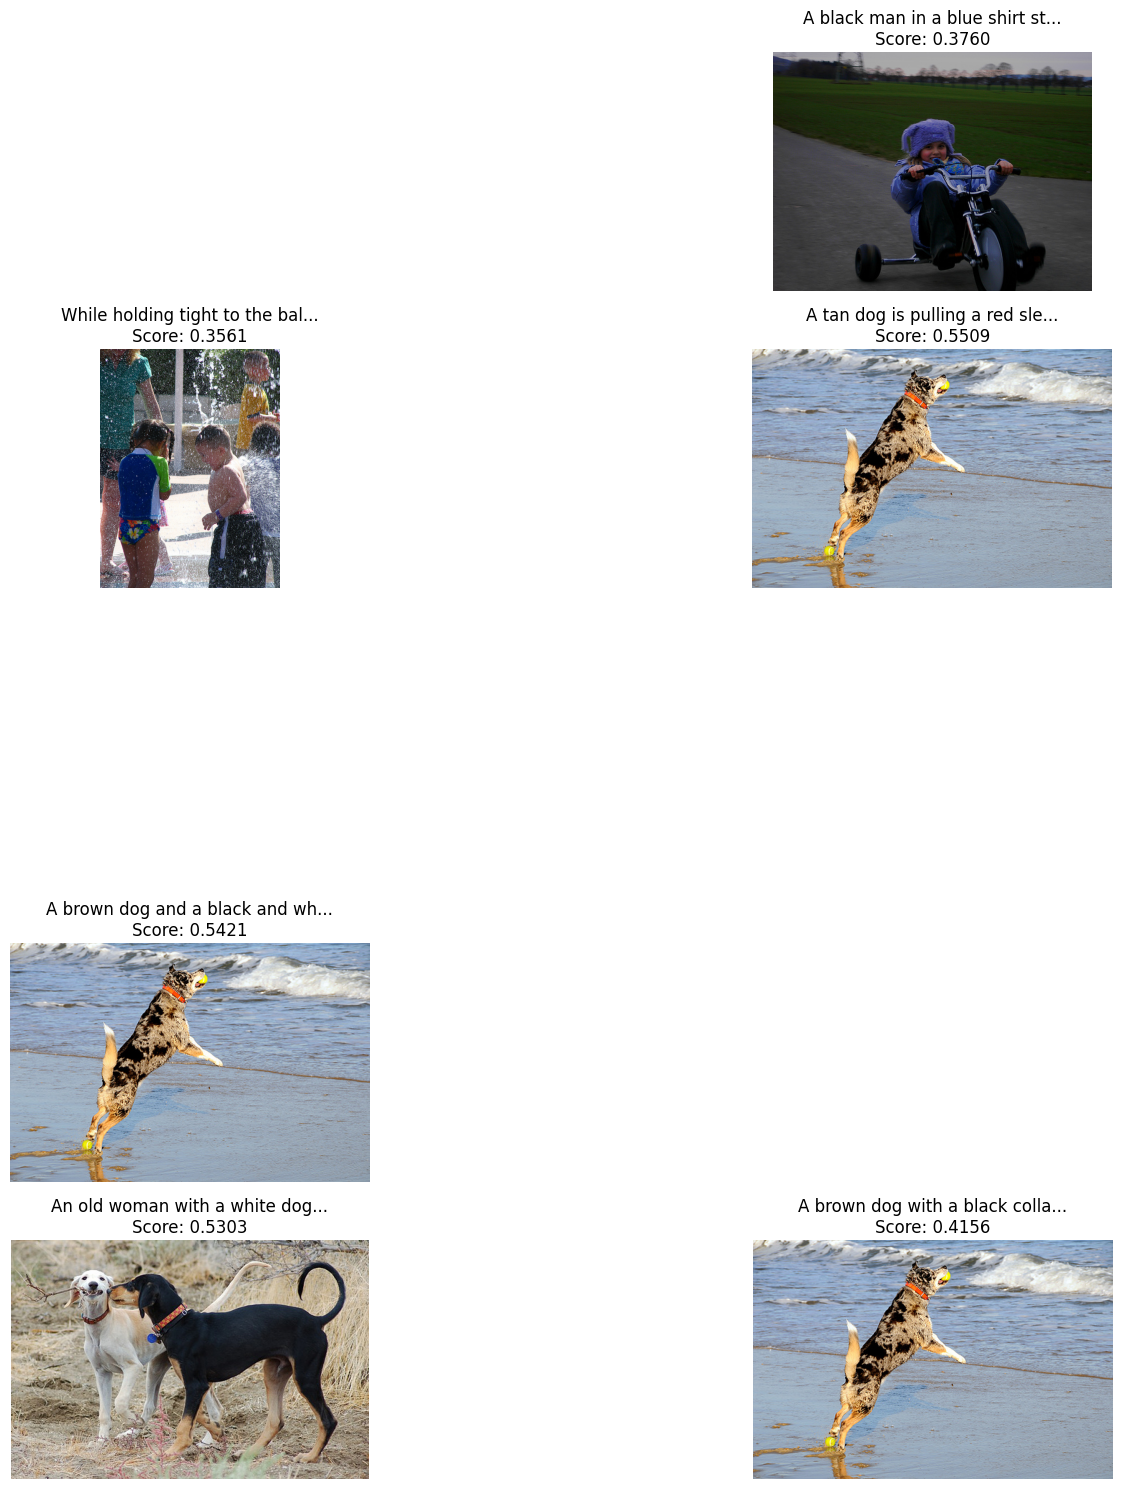

In [35]:
sample_queries = final_test_df['query_text'].dropna().sample(10).tolist()

plt.figure(figsize=(15, 15))

for i, query in enumerate(sample_queries):
    result = find_most_relevant_image(query, cat_model, test_image_vectors, test_image_names, vectorizer)
    
    if isinstance(result, str):  # Дисклеймер
        print(f"Query: {query}\nResult: {result}\n")
        continue
    
    img_name, score = result
    img_path = os.path.join(final_test_image_dir, img_name)
    
    img = Image.open(img_path)
    
    plt.subplot(5, 2, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{query[:30]}...\nScore: {score:.4f}")

plt.tight_layout()
plt.show()


# Итоговый вывод

Наша цель - разработать демонстрационную версию поиска изображений по запросу.
Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

Использовали фреймворк Keras.

**Первичный осмотр и редактура**

После **загрузки** увидели такую картину:
- Тренировочный датасет 5822 строки;
- Экспертный аналогично, 5822;
- Краундовый 47830 строк;
- Тестовый 500 строк.

Изображения в тренировочном датасете:
Количество изображений: 1000;
Средний размер изображений: 455.9 x 398.3

Изображения в тестовом датасете:
Количество изображений: 100;
Средний размер изображений: 461.4 x 386.4

После построения графиков для датасетов встал вопрос доверия - в краундинговом датасете оценки ставили люди не имеющие, так сказать, профессионализма при выборе. Кроме того, такие не совсем ясные и порой неточные оценки сильно будут размывать итоговый балл, который по итогу может быть некорректным. Судя по графикам, экспертные оценки имеют более сбалансированный датасет, плавное распределение оценок. Краундинговый датасет содержит огромное количество несовпавших картинок с текстом, это сильно повлияет на обучение. Выбрали для исследования и работы экспертов.

Соединили датафреймы по логие inner join через merge. Итоговым расчетом баллов была выбран метод среднего по всем экспертам.

Для выполнения задачи юридических ограничений мы создали список слов, связь с изображениями которых была очевидна. Это слова которые указывают на наличие в изображении лиц не достигших 16-летного возраста. Удалили эти строки.

**Получение векторов текста и изображений**

Этап обработки текста использовали модуль Stanza и векторизацию через TF-IDF. Векторов было создано 937 элементов.

Обработка изображений проводилась через Resnet50. Так как Resnet50 обучался на отредактированных изображениях то изменили размер на 224 на 224, обрезали центр и нормализовали. Векторов создано 699 изображений.

Объединили вектора и привели эмбединги к единичной форме. Разделили выборки методом GroupShuffleSplit чтобы одно и то же изображение не попало в разные выборки.

**Обучение моделей**

Для достижения цели работы рассмотрели несколько моделей. Мы выбрали:

    линейную регрессию
    полносвязнную нейронную сеть
    сверточную нейронную сеть
    CatBoost
    
Результат работы всех 4 моделей на валидационной выборке показан в таблице:

**Linear Regression**     -1.0726

**Fully-connected NN**     0.2629 

**CNN + Text NN**         -2.5779 

**CatBoost Regressor**     0.3027


Лучшей моделью по метрике является CatBoost Regressor.

**Демонстрационная версия**

Финальным актом работы являлось применение демонстрационной версии. Сделали такие шаги:

    получиkb на вход текст;
    обработали, токенизировали, векторизировали;
    из тестовых данных создали 100 конкатенированных пар;
    подали эти пары на вход обученной модели;
    получили изображения которые имеют максимальный балл;

**Вывод**
Модель не совсем успешно выдает нужные результаты, это связано с исходным материалом работы. Данных слишком мало и они очень сильно перекошены в сторону нулевых баллов.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Проверены экспертные оценки и краудсорсинговые оценки
- [x]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [x]  Изображения векторизованы
- [x]  Текстовые запросы векторизованы
- [x]  Данные корректно разбиты на тренировочную и тестовую выборки
- [x]  Предложена метрика качества работы модели
- [x]  Предложена модель схожести изображений и текстового запроса
- [x]  Модель обучена
- [x]  По итогам обучения модели сделаны выводы
- [x]  Проведено тестирование работы модели
- [x]  По итогам тестирования визуально сравнили качество поиска